In [1]:
import pandas as pd
import numpy as np
import os.path, sys
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegressionCV, LassoCV, LogisticRegression
import importlib
import pickle
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
print(os.getcwd())
fileloc_data='/'.join(os.getcwd().split('/')[0:5])+ '/data/annonymizedDatasets/'
name_mapping=pd.read_csv('/'.join(os.getcwd().split('/')[0:5])+ '/data/Map_1.csv', sep=',')
savetag='pred_lavSQ_MHC'
print(fileloc_data)
code_path='/'.join(os.getcwd().split('/')[0:4])+'/sklvq/'
sys.path.append(code_path)
from sklvq import GMLVQ, LGMLVQ
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis,)
from sklearn.svm import SVC
from EDdataset_GGZ import colsTypeCast
%load_ext autoreload
from GetDataReady import getDataNormalized

/home/sreejita/ProjectsPy/GGZ/code_scripts/ED-profiling
/home/sreejita/ProjectsPy/GGZ/data/annonymizedDatasets/
/home/sreejita/ProjectsPy/GGZ/code_scripts/ED-profiling


In [2]:
choice_dict={1.0: 'Core-DT, 5Cls', 1.1: 'Core-DT, only ED', 1.2: 'Core-DT, 3 ED and Others',
    2.0: 'Core-DT-EDEQ subscale, 5Cls', 2.1: 'Core-DT-EDEQ subscale, only ED', 2.2: 'Core-DT-EDEQ subscale, 3 ED and Others',
    3.0: 'Core, 5Cls', 3.1: 'Core, only ED', 3.2: 'Core, 3 ED and Others'}
save_dict={1.0: 'Core-DT-5Cls', 1.1: 'Core-DT-onlyED', 1.2: 'Core-DT-3ED-Others',
    2.0: 'Core-DT-EDEQ-5Cls', 2.1: 'Core-DT-EDEQ-only-ED', 2.2: 'Core-DT-EDEQ-3ED-Others',
    3.0: 'Core-5Cls', 3.1: 'Core-onlyED', 3.2: 'Core-3ED-Others'}
use_permutation_imp=['KNN','LDA','QDA','LSVC','RSVC']
savepicklpath='%s/pickles/'%(os.getcwd())
dataset_types={}
for key, val in choice_dict.items():
    dataset_types[key]=getDataNormalized(key)
ftr_imp_pkls='%s/rearr_ftr_weights.pkl'%savepicklpath
if os.path.exists('%s/rearr_ftr_weights.pkl'%savepicklpath):
    with open('%s/rearr_ftr_weights.pkl'%savepicklpath, 'rb') as f: 
        fimp_all_exps=pickle.load(f)
if os.path.exists('%s/rearr_prots_lvq.pkl'%savepicklpath):
    with open('%s/rearr_prots_lvq.pkl'%savepicklpath, 'rb') as f:  # open a text file
        prots_lvq_all=pickle.load(f) 

1.0: For dataset with Core, DT, and 5 classes (Ndims=24):

1.1: For dataset with Core, DT and only ED classes:

1.2: For dataset with Core, DT and 3 ED classes and Others:

2.0: For dataset with Core, DT, EDEQ subscales and all 5 classes (Ndim=27):

2.1: For dataset with Core, DT, EDEQ subscales, and only ED classes:

2.2: For dataset with Core, DT, EDEQ subscales and 3 ED classes and Others:

3.0: For dataset with Core only, and all 5 classes (Ndim=16):

3.1: For dataset with Core only, and only ED classes:

3.2: For dataset with Core, and 3 ED classes and Others:



In [15]:
choice=2.2
select_keys1, classifier_name1=['RF', 'KNN','RSVC', 'LDA','GMLVQ'],['Random Forest', 'K-nearest neighbour', 'SVM w/ RBF',
                                                                    'Linear Discr. Analysis','Generalized Matrix LVQ']
select_keys2, exp_name=['GNB','LGMLVQ2', 'LogLASSO'], save_dict[choice]
X, Y=dataset_types[choice]['zXtrain'], dataset_types[choice]['Ytrain']
Xtest=dataset_types[choice]['zXtest']
X.rename(columns=dict(zip(name_mapping['Current'].to_list(), name_mapping['Updated'].to_list())), inplace=True)
Xtest.rename(columns=dict(zip(name_mapping['Current'].to_list(), name_mapping['Updated'].to_list())), inplace=True)
nclasses, fimp_all=len(np.unique(Y)), fimp_all_exps[choice]
adapted_combo_cols=X.columns
ind = np.arange(len(adapted_combo_cols)-1)
mean_name, std_name, show_col_names=[],[], []
for idx, col in enumerate(adapted_combo_cols):
    if (col.split('-')[0]=='Main') | (col=='DT-BMI'):
        col=col.split('-')[1]   
    show_col_names.append(' '.join(col.split('_')))
    col='('+col+')'
    all_parts=' '.join(col.split('_'))    
    #temp='mean '+ all_parts
    mean_name.append('mean '+ all_parts)
   # temp='std '+ all_parts
    std_name.append('std '+ all_parts)

mpl.rcParams['hatch.linewidth'] = 0.5
res_df_colname=np.column_stack((mean_name, std_name)).flatten()
patterns = [ "/" , "++", "..", "xx", "\\" , "+" , "o", "O", "*", "|"  ]
colors=[np.array([228,26,28])/256, np.array([200,0,210])/256, np.array([77,175,74])/256, np.array([56,108,176])/256, 
        np.array([255,127,0]) /256, np.array([191,91,23])/256, np.array([231,41,138])/256, np.array([247,129,191])/256]
fs, alpha, ind2=10,0.6, ind
print(exp_name)
print(np.unique(Y))

Core-DT-EDEQ-3ED-Others
['Anorexia nervosa' 'Binge-ED' 'Bulimia nervosa' 'Others']


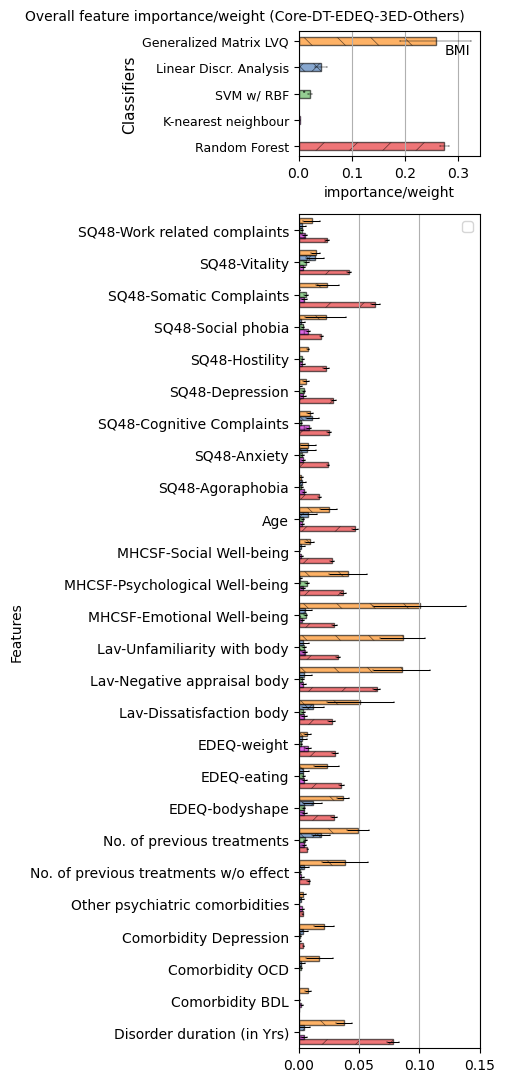

In [16]:
bar_width = 0.15# the width of the bars
shifts=[-0.3,-0.15,0.0,0.15,0.30]#shifts=[-0.4,-0.20,0.0,0.20,0.40]#fig, ax = plt.subplots(1,2, figsize=(9,5))
fig = plt.figure(constrained_layout=True, figsize=(5,11))
widths, ax_all, annot_pos =[0.15,1],[],[]
spec = fig.add_gridspec(ncols=1, nrows=2, height_ratios=widths)
for colnum in range(2):
    ax_all.append(fig.add_subplot(spec[colnum]))
ax, rects_all, bmi_all, fimp_tabulate, fimp_tabulate, highs=ax_all[1],{},{},{},{},[]
for idx,key in enumerate(select_keys1):
    if key in use_permutation_imp:
        bardata, err=np.mean(fimp_all[key]['All'], axis=1), np.std(fimp_all[key]['All'], axis=1)
    else:
        bardata, err=np.mean(fimp_all[key]['All'], axis=0), np.std(fimp_all[key]['All'], axis=0)
    rects_all[key] = ax.barh(ind+shifts[idx], bardata[1:], height=bar_width*0.99, xerr=err[1:], label=key, 
                           error_kw=dict(lw=0.75, capsize=0.5, capthick=0.3), hatch=patterns[idx], color=colors[idx], alpha=alpha, edgecolor='k')    
    ax_all[0].barh(idx, bardata[0], xerr=err[0], hatch=patterns[idx], height=bar_width*2, color=colors[idx], alpha=alpha, edgecolor='k',
                   error_kw=dict(lw=0.3, capsize=0.5, capthick=0.3))
    highs.append(np.max(bardata[1:]))
    annot_pos.append(bardata[0]+err[0])   
    mean_err=(np.column_stack((bardata, err))).flatten()
    fimp_tabulate[key]=mean_err
fimp_tabulate=pd.DataFrame.from_dict(data=fimp_tabulate).T
fimp_tabulate.columns=res_df_colname
ax.set_ylabel('Features', fontsize=fs)
ax.set_yticks(ind)
ax.set_yticklabels(show_col_names[1:], rotation=0, fontsize=fs)
ax.legend('')
ax.grid(axis='x')
ax.set_xlim(0,np.max(highs)+0.05)
ax.set_ylim(-0.5,len(show_col_names)-1.5)
ax_all[0].set_yticks(np.arange(0,len(select_keys1)))
ax_all[0].set_yticklabels(classifier_name1, rotation=0, fontsize=fs-1)
ax_all[0].set_ylabel('Classifiers', fontsize=fs+1)
ax_all[0].set_xlabel('importance/weight', fontsize=fs)
ax_all[0].grid(axis='x')
ax_all[0].annotate('BMI', xy=(np.max(annot_pos)-0.05, 3.5))
#ax_all[0].text(np.max(highs)-0.02, 3, 'BMI', fontsize=fs)
fig.suptitle('Overall feature importance/weight (%s)'%exp_name, fontsize=fs)
fig.tight_layout()
plt.show()
fig.savefig('figs/PDFs/classification/FIMP1%s_vert.pdf'%exp_name, bbox_inches='tight', transparent=False,
               pad_inches=0.01)
fig.savefig('figs/PNGs/classification/FIMP1_%s_vert.png'%exp_name, bbox_inches='tight', transparent=True,
               pad_inches=0.01)

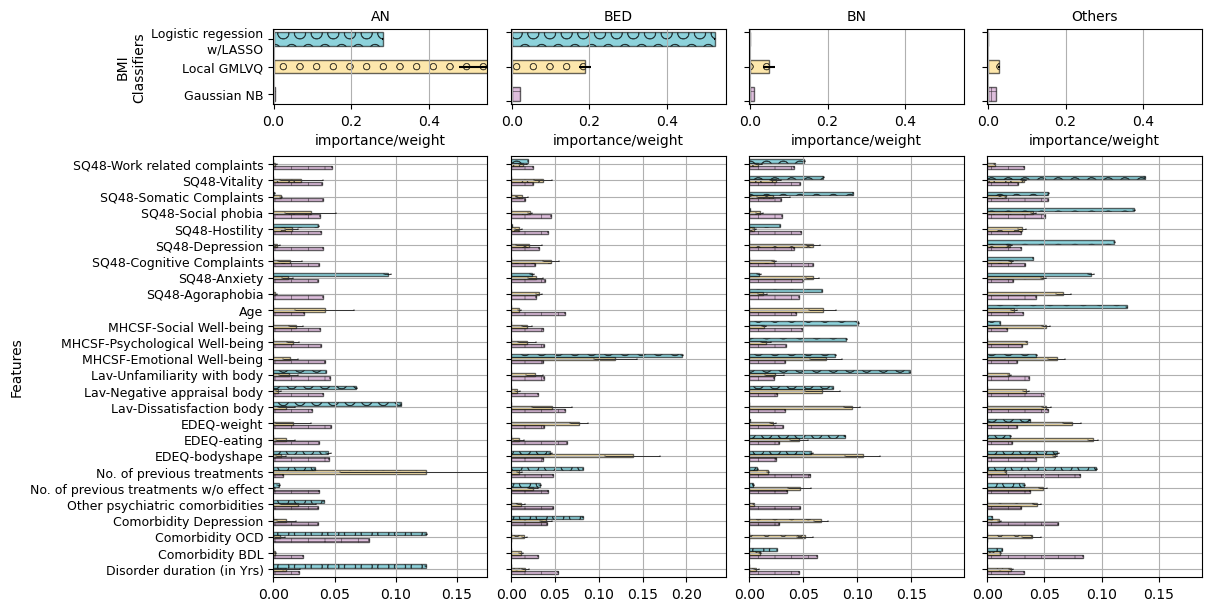

In [17]:
select_keys2=['GNB','LGMLVQ2', 'LogLASSO']
colors_cw=[[201,148,199],[254,217,118], [65,182,196]]
classifier_names=['Gaussian NB','Local GMLVQ', 'Logistic regession\n w/LASSO']
Cls_dict=dict(zip(['Anorexia nervosa','Binge-ED','Bulimia nervosa', 'Other ED', 'Others'], ['AN','BED','BN', 'OED', 'Others']))
bar_width = 0.2  # the width of the bars#shifts=[-0.48, -0.33,-0.167, 0.167,0.33,0.48]
shifts=[-0.2,0.0,0.2]
ind2=ind[1:4]#fig1, ax1 = plt.subplots(nclasses,1, figsize=(8,7), sharex=True)
fig1 = plt.figure(constrained_layout=True, figsize=(12,6))
heights, widths, ax1, ax11=[0.18,1],np.ones(nclasses),[],[]
spec = fig1.add_gridspec(ncols=nclasses, nrows=2, width_ratios=widths, height_ratios=heights)
for colnum in range(nclasses):
    ax1.append(fig1.add_subplot(spec[1,colnum]))
    ax11.append(fig1.add_subplot(spec[0,colnum]))
rects_all, fimp_tabulate_cw={},{}
for cls in range(0, nclasses):
    highs=[]
    for idx,key in enumerate(select_keys2):
        clsName=fimp_all_exps[choice][key]['cls_names'][cls]#pipeClassifiers_all[key][0][key].classes_[cls]
        bardata, err=np.mean(fimp_all[key]['C%d'%(cls+1)]['All'], axis=0), np.std(fimp_all[key]['C%d'%(cls+1)]['All'], axis=0)
        rects_all[key] = ax1[cls].barh(ind +shifts[idx], bardata[1:], height=bar_width, xerr=err[1:], label=key,
                                       color=np.array(colors_cw[idx])/256,hatch=patterns[idx+len(select_keys1)],alpha=alpha, edgecolor='k',
                           error_kw=dict(lw=0.5, capsize=0.5, capthick=0.3))
        mean_err=(np.column_stack((bardata, err))).flatten()
        fimp_tabulate_cw[key+'-'+Cls_dict[clsName]]=mean_err     
        ax11[cls].barh(shifts[idx], bardata[0], height=bar_width*0.5, xerr=err[0], color=np.array(colors_cw[idx])/256,alpha=alpha, edgecolor='k',
                       hatch=patterns[idx+len(select_keys1)])
        highs.append(np.max(bardata[1:]))
# Add some text for labels, title and custom x-axis tick labels, etc.    
    axis_intervals=np.arange(0,0.2,0.05)
    ax1[cls].set_xticks(axis_intervals, minor=True)
    ax1[cls].grid() 
    ax11[cls].grid(axis='x')   
    ax11[cls].set_title('%s'%Cls_dict[clsName], fontsize=fs) 
    ax11[cls].set_xlabel('importance/weight', fontsize=fs)     
    ax1[cls].set_xlim(0,np.max(highs)+0.05)
    ax11[cls].set_xlim(-0.001,0.55)
    ax1[cls].set_yticks(ind)
    ax1[cls].set_ylim(-0.5,len(show_col_names)-1.5)
    if cls==0:
        ax1[cls].set_yticklabels(show_col_names[1:], rotation=0, fontsize=fs-1)
        ax1[cls].set_ylabel('Features', fontsize=fs)
    else:       
        ax1[cls].set_yticklabels([])
        ax11[cls].set_yticklabels([])
ax11[0].set_yticks(shifts)
ax11[0].set_yticklabels(classifier_names, rotation=0, fontsize=fs-1)
ax11[0].set_ylabel('BMI\nClassifiers', fontsize=fs)
fimp_tabulate_cw=pd.DataFrame.from_dict(data=fimp_tabulate_cw).T
fimp_tabulate_cw.columns=res_df_colname
fig.suptitle(exp_name, fontsize=fs)
fig.tight_layout()
plt.show()
fig1.savefig('figs/PDFs/classification/FIMP2_%s_vert.pdf'%exp_name, bbox_inches='tight', transparent=False,\
               pad_inches=0.01)
fig1.savefig('figs/PNGs/classification/FIMP2_%s_vert.png'%exp_name, bbox_inches='tight', transparent=False,\
               pad_inches=0.01)
fimp_tabulate_all=pd.concat([fimp_tabulate, fimp_tabulate_cw])
fimp_tabulate_all.to_csv('tabs/Feature_wgt_imp_%s.csv'%exp_name, sep='\t', decimal='.', index=True)

In [18]:
select_keys2, classifier_prot=['GMLVQ','LGMLVQ2'], ['Generalized Matrix LVQ', 'Localized GMLVQ']
fs, nprots, prot_cls=9, np.shape(prots_lvq_all[choice]['GMLVQ']['Mean'])[0],[]
Cls_dict=dict(zip(prots_lvq_all[choice]['GMLVQ']['cls_names'], ['AN','BED','BN', 'OED', 'Others']))
Prot_dict=dict(zip(prots_lvq_all[choice]['GMLVQ']['cls_names'], prots_lvq_all[choice]['GMLVQ']['prot_per_cls']))
for clsName, prots in Prot_dict.items():
    for idx in range(prots):
        prot_cls.append('%s-%d'%(Cls_dict[clsName],idx+1))
print(np.shape(prots_lvq_all[2.1]['GMLVQ']['Mean']))
print(Prot_dict)
ind, nprots = np.arange(len(adapted_combo_cols)), np.sum(prots_lvq_all[choice]['GMLVQ']['prot_per_cls'])
width, shifts = 0.25, [-0.125,0.125] # the width and rel positions of the bars 
rects_all={}
norm_profile_all, profile_all={},{}
prof_mean, prof_std=dataset_types[choice]['mean'], dataset_types[choice]['std']
for prot in range(nprots):
    true_scale=np.zeros((np.shape(prots_lvq_all[choice]['GMLVQ']['All'])[0], np.shape(prots_lvq_all[choice]['GMLVQ']['All'])[2]))
    for idx,key in enumerate(['GMLVQ','LGMLVQ2']):
        clsName=prot_cls[prot]#pipeClassifiers_all[key][0][key].classes_[cls]
        bardata, err=prots_lvq_all[choice][key]['Mean'][prot], prots_lvq_all[choice][key]['Std'][prot]        
        mean_err=(np.column_stack((bardata, err))).flatten()
        norm_profile_all[key+'-'+clsName]=mean_err
        for iter in range(np.shape(prots_lvq_all[choice]['GMLVQ']['All'])[0]):
            true_scale[iter, :]=(prots_lvq_all[choice][key]['All'][iter][prot]*prof_std)+prof_mean       
        profile_all[key+'-'+clsName]=(np.column_stack((np.mean(true_scale, axis=0), np.std(true_scale, axis=0)))).flatten()
profile_all=pd.DataFrame.from_dict(data=profile_all).T
profile_all.columns=res_df_colname
norm_profile_all=pd.DataFrame.from_dict(data=norm_profile_all).T
norm_profile_all.columns=res_df_colname
norm_profile_all.to_csv('tabs/normed_CW_Profiles_%s.csv'%exp_name, sep='\t', decimal='.', index=True)
profile_all.to_csv('tabs/CW_Profiles_%s.csv'%exp_name, sep='\t', decimal='.', index=True)

(8, 27)
{'Anorexia nervosa': 3, 'Binge-ED': 2, 'Bulimia nervosa': 1, 'Others': 1}


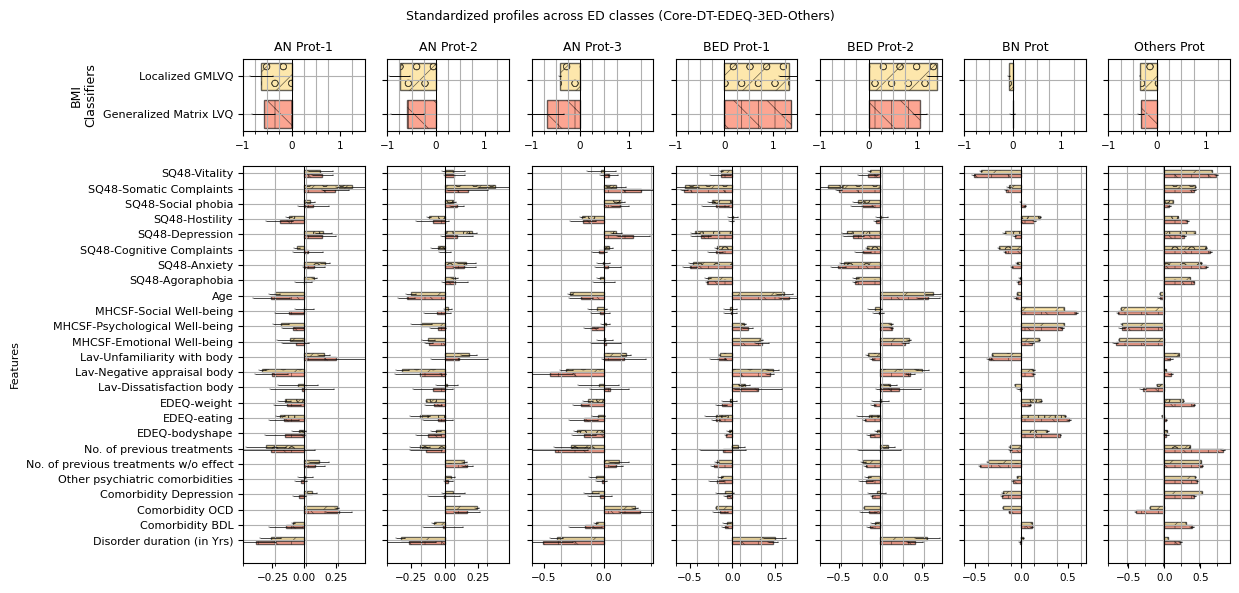

In [19]:
fig3 = plt.figure(constrained_layout=True, figsize=(12.5,6))
cols_cw_prot=[[251,106,74],[254,217,118]]
prof_hatch=['\\|','/o', '|*', '-\\', '+o', 'x*', 'o-', 'O|', 'O.', '*-']
select_keys2, classifier_prot=['GMLVQ','LGMLVQ2'], ['Generalized Matrix LVQ', 'Localized GMLVQ']
fs, nprots=9, np.shape(prots_lvq_all[choice]['GMLVQ']['Mean'])[0]
Cls_dict=dict(zip(['Anorexia nervosa','Binge-ED','Bulimia nervosa', 'Other ED', 'Others'], ['AN','BED','BN', 'OED', 'Others']))
Prot_dict=dict(zip(prots_lvq_all[choice]['GMLVQ']['cls_names'], prots_lvq_all[choice]['GMLVQ']['prot_per_cls']))
prot_cls=[]
for clsName, prots in Prot_dict.items():
    for idx in range(prots):        
        if prots==1:#Prot_dict[clsName]==1:
            prot_cls.append('%s Prot'%(Cls_dict[clsName]))
        else:
            prot_cls.append('%s Prot-%d'%(Cls_dict[clsName],idx+1))
heights, widths, ax3, ax31 =[0.18,1],np.ones(nprots),[],[]
spec3 = fig3.add_gridspec(ncols=nprots, nrows=2, width_ratios=widths, height_ratios=heights)
for colnum in range(nprots):
    ax3.append(fig3.add_subplot(spec3[1,colnum]))
    ax31.append(fig3.add_subplot(spec3[0,colnum]))
rects_all={}
shift_bmi=[-0.25, .025]
norm_profile_all, profile_all={},{}
prof_mean, prof_std=dataset_types[choice]['mean'], dataset_types[choice]['std']
for prot in range(nprots):
    true_scale, highs, lows=np.zeros((np.shape(prots_lvq_all[choice]['GMLVQ']['All'])[0], np.shape(prots_lvq_all[choice]['GMLVQ']['All'])[2])),[],[]
    for idx,key in enumerate(['GMLVQ','LGMLVQ2']):
        clsName=prot_cls[prot]#pipeClassifiers_all[key][0][key].classes_[cls]
        bardata, err=prots_lvq_all[choice][key]['Mean'][prot], prots_lvq_all[choice][key]['Std'][prot]        
        rects_all[key] = ax3[prot].barh(ind[1:] +shifts[idx], bardata[1:], height=bar_width, xerr=err[1:], label=key, 
                color=np.array(cols_cw_prot[idx])/256, hatch=prof_hatch[idx],alpha=alpha, edgecolor='k',
                                        error_kw=dict(lw=0.5, capsize=0.5, capthick=0.2, ecolor='k'))
        mean_err=(np.column_stack((bardata, err))).flatten()
        highs.append(np.max(bardata[1:]))
        lows.append(np.min(bardata[1:]))
        norm_profile_all[key+'-'+clsName]=mean_err
        for iter in range(np.shape(prots_lvq_all[choice]['GMLVQ']['All'])[0]):
            true_scale[iter, :]=(prots_lvq_all[choice][key]['All'][iter][prot]*prof_std)+prof_mean       
        ax31[prot].barh(shift_bmi[idx], bardata[0], height=bar_width, xerr=err[0], 
                        color=np.array(cols_cw_prot[idx])/256,hatch=prof_hatch[idx],alpha=alpha, edgecolor='k', 
                        error_kw=dict(lw=0.65, capsize=0.5, capthick=0.2, ecolor='k'))
# Add some text for labels, title and custom x-axis tick labels, etc.    
    ax3[prot].set_xlim(np.min(lows)-0.1,np.max(highs)+0.1)
    minor_ticks, minor_ticks2 = np.arange(np.min(lows)-0.1,np.max(highs)+0.1, 0.25), np.arange(-1, 1.5, 0.25)
    ax3[prot].set_xticks(minor_ticks, minor=True)
    ax3[prot].grid(which='minor')     
    ax31[prot].set_title('%s'%clsName, fontsize=fs)    
    ax31[prot].set_xticks(minor_ticks2, minor=True)
    ax31[prot].grid(axis='x', which='minor')  
    ax31[prot].grid(axis='y', which='major')  
    ax3[prot].grid(axis='y', which='major')  
    ax31[prot].set_xlim(-1,1.5)
    ax3[prot].set_yticks(ind[1:])
    ax31[prot].axvline(x = 0.0, color = 'k', linestyle = '-', linewidth=0.75) 
    ax3[prot].axvline(x = 0.0, color = 'k', linestyle = '-', linewidth=0.75) 
    ax3[prot].set_ylim(-0.5,len(show_col_names)-1.5)
    ax31[prot].set_xticklabels(ax31[prot].get_xticklabels(), fontsize=fs-1.5, rotation=0)
    ax3[prot].set_xticklabels(ax3[prot].get_xticklabels(), fontsize=fs-1.5, rotation=0)
    if prot==0:        
        ax3[prot].set_yticklabels(show_col_names[1:], rotation=0, fontsize=fs-1)
        ax3[prot].set_ylabel('Features', fontsize=fs-1)
    else:       
        ax3[prot].set_yticklabels([])
        ax31[prot].set_yticklabels([])
ax31[0].set_yticks(shift_bmi)
ax31[0].set_yticklabels(classifier_prot, rotation=0, fontsize=fs-1)
ax31[0].set_ylabel('BMI\nClassifiers', fontsize=fs)
fig3.suptitle('Standardized profiles across ED classes (%s)'%exp_name, fontsize=fs)
fig3.tight_layout()
plt.subplots_adjust(wspace=None, hspace=None)
fig3.savefig('figs/PDFs/classification/Prots_%s_vert.pdf'%exp_name, bbox_inches='tight', transparent=False,\
               pad_inches=0.01)
fig3.savefig('figs/PNGs/classification/Prots_%s_vert.png'%exp_name, bbox_inches='tight', transparent=False,\
               pad_inches=0.01)